In [ ]:
nb = MultinomialNB()

nb.fit(X_train_vectorized, y_train)

fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(nb, X_train_vectorized, y_train, ax=ax, cmap="cividis");

In [ ]:
# get the coefficient and sort them
coef = nb.coef_[0]
top_positive_coefficients = np.argsort(coef)[:10]


plt.figure(figsize=(15, 10))
colors = ['red' if c < 0 else 'blue' for c in coef[top_positive_coefficients]]
plt.barh(np.arange(len(top_positive_coefficients)), coef[top_positive_coefficients], color=colors)
feature_names = np.array(vectorizer.get_feature_names())
plt.yticks(np.arange(len(top_positive_coefficients)), feature_names[top_positive_coefficients], rotation=0, ha='right')
plt.ylabel('Features')
plt.xlabel('Coefficient')
plt.title('Most Predictive Features and Associated Coefficients - Naive Bayes')
plt.show()

In [ ]:
from sklearn.metrics import f1_score

def plot_feature_importance(model, X, y):
    y = np.array(y)  # Convert y to numpy array
    target_names = np.unique(y)
    n_targets = len(target_names)
    
    if hasattr(model, 'feature_importances_'):
        feat_imp_all = model.feature_importances_.reshape(n_targets, -1)
    else:
        feat_imp_all = np.log(np.abs(model.coef_))
    
    f1_scores = []
    for t in range(n_targets):
        X_subset = X[np.where(y == target_names[t])]
        y_subset = y[np.where(y == target_names[t])]
        y_pred_subset = model.predict(X_subset)
        f1_scores.append(f1_score(y_subset, y_pred_subset, average='weighted'))
    
    f1_scores = np.array(f1_scores)
    plt.figure(figsize=(15, 10))
    colors = ['r', 'g', 'b']
    all_sorted_idx = []
    
    for t, target_name in enumerate(target_names):
        feat_imp = 100.0 * (feat_imp_all[t] * f1_scores[t] / feat_imp_all[t].max())
        sorted_idx = np.argsort(feat_imp)[::-1][:10]
        all_sorted_idx.extend(sorted_idx)

        plt.bar(np.arange(t * 10, t * 10 + 10), feat_imp[sorted_idx], color=colors[t], alpha=.7)

    plt.xticks(np.arange(30), np.array(vectorizer.get_feature_names())[all_sorted_idx], rotation=90)
    plt.title("Top 10 Feature Importances for Each Target (weighted by f1_score)")
    plt.legend(target_names)
    plt.show()

plot_feature_importance(nb, X_train_vectorized, y_train)

In [ ]:
# plot for feature importance


nb = MultinomialNB()

nb.fit(X_train_vectorized, y_train)

feature_importances = nb.coef_[0]

feature_importances_sorted = sorted(zip(feature_importances, vectorizer.get_feature_names()), reverse=True)

N = 20
top_features = [f[1] for f in feature_importances_sorted[:N]]
top_importances = [f[0] for f in feature_importances_sorted[:N]]

plt.barh(np.arange(len(top_features)), top_importances)
plt.yticks(np.arange(len(top_features)), top_features)
plt.title('Top {} Most Important Features'.format(N))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [45]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, make_scorer, plot_confusion_matrix
from wordcloud import WordCloud

from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTENC, SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

import matplotlib.pyplot as plt
import seaborn as sns

from code.cleaner import preprocess
from code.viz import word_plot

from joblib import parallel_backend, dump, load

sns.set()

In [ ]:
#dill = load('./data/best_estimator.pkl')

In [46]:
sentiments = pd.read_csv('./data/judge-1377884607_tweet_product_company.csv',encoding='ISO-8859-1')
sentiments.tail()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product
9092,Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...,NaN,No emotion toward brand or product


In [47]:
sentiments.rename(columns={
    'emotion_in_tweet_is_directed_at':'product',
    'is_there_an_emotion_directed_at_a_brand_or_product':'sentiment'
},inplace=True)

In [48]:
sentiments.dropna(subset=['tweet_text'],inplace=True)

In [49]:
reclassify = sentiments[sentiments['sentiment'] == "I can't tell"]
sentiments = sentiments[sentiments['sentiment'] != "I can't tell"]

In [7]:
sentiments['tokenized'], sentiments['tokens'] = \
    preprocess(sentiments['tweet_text'], ret_tokens=True)

In [34]:
from matplotlib.colors import ListedColormap
test_map = ListedColormap(sns.color_palette('dark',as_cmap=True))

In [ ]:
sns.color_palette()

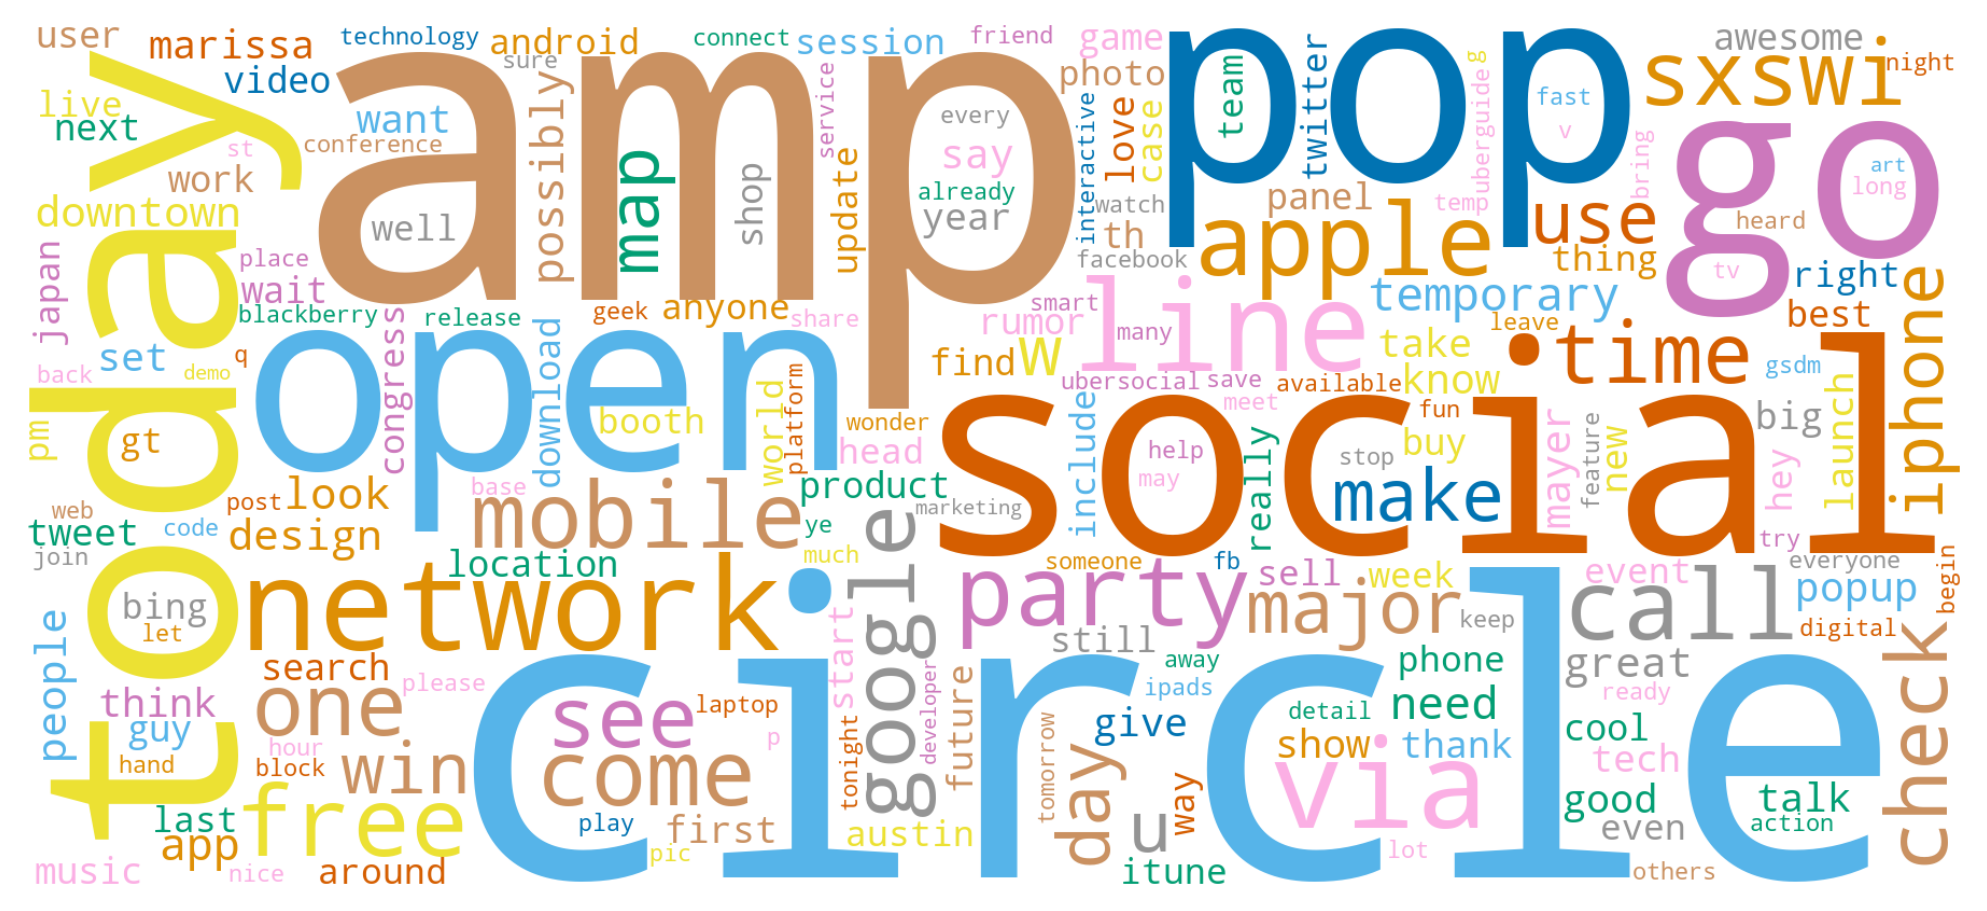

In [31]:
wordcloud = WordCloud(
    collocations=False, width=1800,height=800,
    colormap=test_map, background_color='white'
    ).generate(' '.join(sentiments['tokenized']))
plt.figure(figsize=(10, 14), dpi=250)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [17]:
sw = stopwords.words('english')
#specific_words = ['@mention','link','sxsw','#sxsw','@sxsw']
specific_words = ['@mention','link','sxsw','#sxsw','@sxsw',
                  'google','iphone', 'ipad', 'android', 'app',
                  'apple', 'rt', 'quot', 'store', 'new', 'austin'
                  'circle', 'get', 'launch', '#ipad'
                 ]
# ^^ these are the original extended stop words from initial data
# discovery and knowledge 
discovered_words = [
    'google','iphone', 'ipad', 'android', 'app',
    'apple', 'rt', 'quot', 'store', 'new', 'austin'
    ]
specific_words.extend(discovered_words)
sw.extend(specific_words)

### Fitting a Naive Bayes Model

$$
\begin{bmatrix}
 & \text{Negative} & \text{Neutral} & \text{Positive} \\
\text{Negative} & \text{True-Neg} & \text{FNeu-Neg} & \text{FP-Neg} \\
\text{Neutral} & \text{False-Neg-Neu} & \text{True-Neu} & \text{False-P-Neu} \\
\text{Positive} & \text{False-Neg} & \text{False-Neu-Pos} & \text{TP} \\
\end{bmatrix}
$$

In [18]:
sentiments['tokenized'], sentiments['tokens'] = \
    preprocess(sentiments['tweet_text'],sw=sw,ret_tokens=True)

Index([], dtype='object')


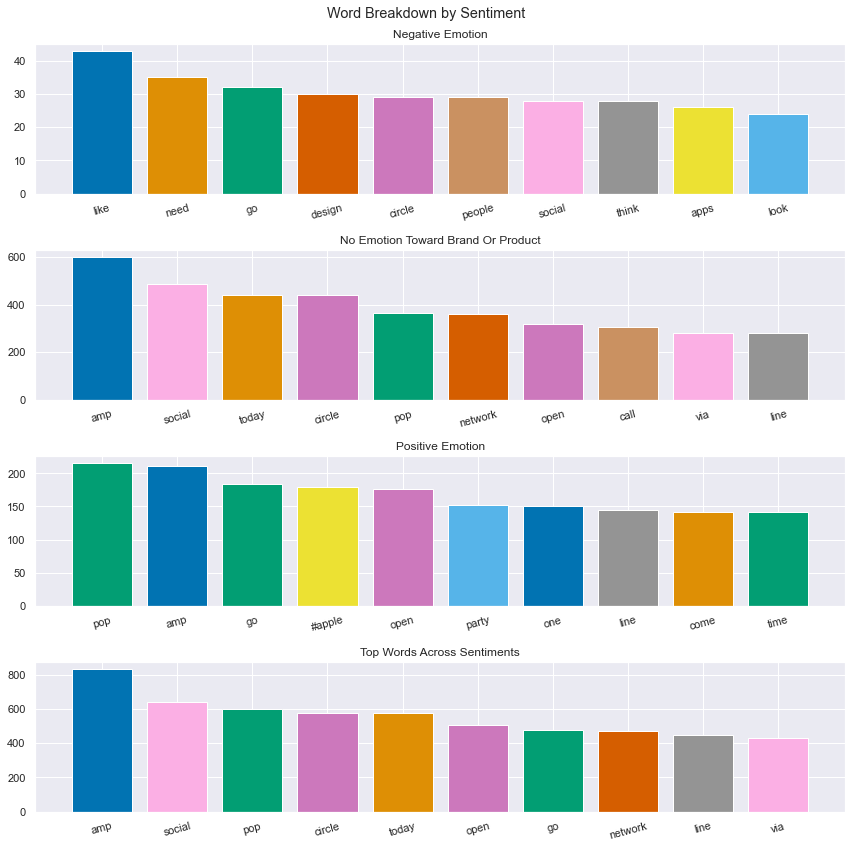

In [20]:
freq_words = word_plot(sentiments,'sentiment','tokens',
    n_words=10, theme= 'colorblind')
print(freq_words[1])

In [ ]:
X2 = sentiments[['tokenized','tokens']]
y2 = sentiments['sentiment']

X_train2, X_test2, y_train2, y_test2 = \
    train_test_split(X2,y2,
        test_size=0.2,
        stratify=y2,random_state=13)

train = X_train2.merge(
    y_train2,left_index=True,right_index=True
    )
test = X_test2.merge(
    y_test2,left_index=True,right_index=True
    )

In [ ]:
len(train)

In [ ]:
sentiments['sentiment'].value_counts()*.8

In [ ]:
sentiments['tokenized']

In [35]:
X = sentiments['tokenized']
y = sentiments['sentiment']

X_train, X_test, y_train, y_test = \
    train_test_split(X,y,
        test_size=0.2,
        stratify=y,random_state=13)

In [36]:
vectorizer = TfidfVectorizer(ngram_range=[1,3],max_df=0.4,min_df=20)

vectorizer.fit(X_train)

TfidfVectorizer(max_df=0.4, min_df=20, ngram_range=[1, 3])

In [37]:
X_train_vectorized = vectorizer.transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [ ]:
majority_length = len(train[train['sentiment'] == 'No emotion toward brand or product'])

In [ ]:
sm_dict = {"No emotion toward brand or product": majority_length,
           "Positive emotion": majority_length*0.5,
           "Negative emotion": majority_length*0.5}

In [38]:
svec = imbPipeline(steps=[
    ('sm', SMOTE(random_state=13)),
    ('svec', SVC(random_state=13))
])

svec.fit(X_train_vectorized, y_train)

Pipeline(steps=[('sm', SMOTE(random_state=13)), ('svec', SVC(random_state=13))])

In [40]:
print(X_train_vectorized)

  (0, 538)	0.8021869004165999
  (0, 341)	0.5970730079311977
  (1, 352)	0.30196388268184354
  (1, 248)	0.4131324139894142
  (1, 208)	0.28190970665741627
  (1, 195)	0.380696199893632
  (1, 159)	0.4566618437547424
  (1, 158)	0.35473430286511276
  (1, 32)	0.4235094775506024
  (2, 684)	0.3578077236884351
  (2, 671)	0.2773052658983984
  (2, 603)	0.3173823044301725
  (2, 587)	0.3386532315028894
  (2, 234)	0.38593165792854295
  (2, 97)	0.4046243509397748
  (2, 55)	0.31132558019920725
  (2, 40)	0.4123956318268684
  (3, 307)	0.4689870691808568
  (3, 208)	0.41132120703603214
  (3, 139)	0.5982128958368146
  (3, 55)	0.5029983348263732
  (4, 665)	0.42545388370826487
  (4, 483)	0.42346256658445836
  (4, 282)	0.4077977866188848
  (4, 231)	0.3249014336911771
  :	:
  (7142, 95)	0.292550190239536
  (7142, 31)	0.787049400761582
  (7143, 673)	0.57148779905134
  (7143, 646)	0.41100520995129586
  (7143, 255)	0.5281220771202417
  (7143, 199)	0.474935242518965
  (7144, 304)	0.6400161597625016
  (7144, 295)	0.4

In [ ]:
preds = svec.predict(X_train_vectorized)
f1_score(y_train, preds, average=None)

In [ ]:
preds = svec.predict(X_test_vectorized)
f1_score(y_test, preds, average=None)

In [ ]:
dill.fit(X_train_vectorized, y_train)

In [ ]:
preds = dill.predict(X_train_vectorized)
f1_score(y_train, preds, average=None)

In [ ]:
preds = dill.predict(X_test_vectorized)
f1_score(y_test, preds, average=None)

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(dill, X_train_vectorized, y_train, ax=ax, cmap="cividis");

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(dill, X_test_vectorized, y_test, ax=ax, cmap="cividis");

In [ ]:
cross_val_score(dill, X_train_vectorized, y_train)

In [ ]:
cross_val_score(svec, X_train_vectorized, y_train, scoring='f1_weighted')

In [ ]:
feature_importances = svec.coef_[0]

feature_importances_sorted = sorted(zip(feature_importances, vectorizer.get_feature_names()), reverse=True)

N = 20
top_features = [f[1] for f in feature_importances_sorted[:N]]
top_importances = [f[0] for f in feature_importances_sorted[:N]]

plt.barh(np.arange(len(top_features)), top_importances)
plt.yticks(np.arange(len(top_features)), top_features)
plt.title('Top {} Most Important Features'.format(N))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [41]:
reclassify = sentiments[sentiments['sentiment'] == "I can't tell"]

In [50]:
sw = stopwords.words('english')
#specific_words = ['@mention','link','sxsw','#sxsw','@sxsw']
specific_words = ['@mention','link','sxsw','#sxsw','@sxsw',
                  'google','iphone', 'ipad', 'android', 'app',
                  'apple', 'rt', 'quot', 'store', 'new', 'austin'
                  'circle', 'get', 'launch', '#ipad'
                 ]
# ^^ these are the original extended stop words from initial data
# discovery and knowledge 
discovered_words = [
    'google','iphone', 'ipad', 'android', 'app',
    'apple', 'rt', 'quot', 'store', 'new', 'austin'
    ]
specific_words.extend(discovered_words)
sw.extend(specific_words)

In [51]:
reclassify['tokenized'], reclassify['tokens'] = \
    preprocess(reclassify['tweet_text'],sw=sw,ret_tokens=True)

In [55]:
vectorizer = TfidfVectorizer(ngram_range=[1,3],max_df=0.4,min_df=20)

X_trains = vectorizer.fit_transform(reclassify['tweet_text'])

In [ ]:
X_train_vectorized = vectorizer.transform(X_train)

In [57]:
svec = imbPipeline(steps=[
    ('sm', SMOTE(random_state=13)),
    ('svec', SVC(random_state=13))
])

svec.fit(X_trains, sentiments['sentiment'])

ValueError: Found input variables with inconsistent numbers of samples: [156, 8936]

In [ ]:
X_train_vectorized = vectorizer.transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)